/scratch/ipykernel_2555859/564656528.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.90, 1])  # leave space for colorbar


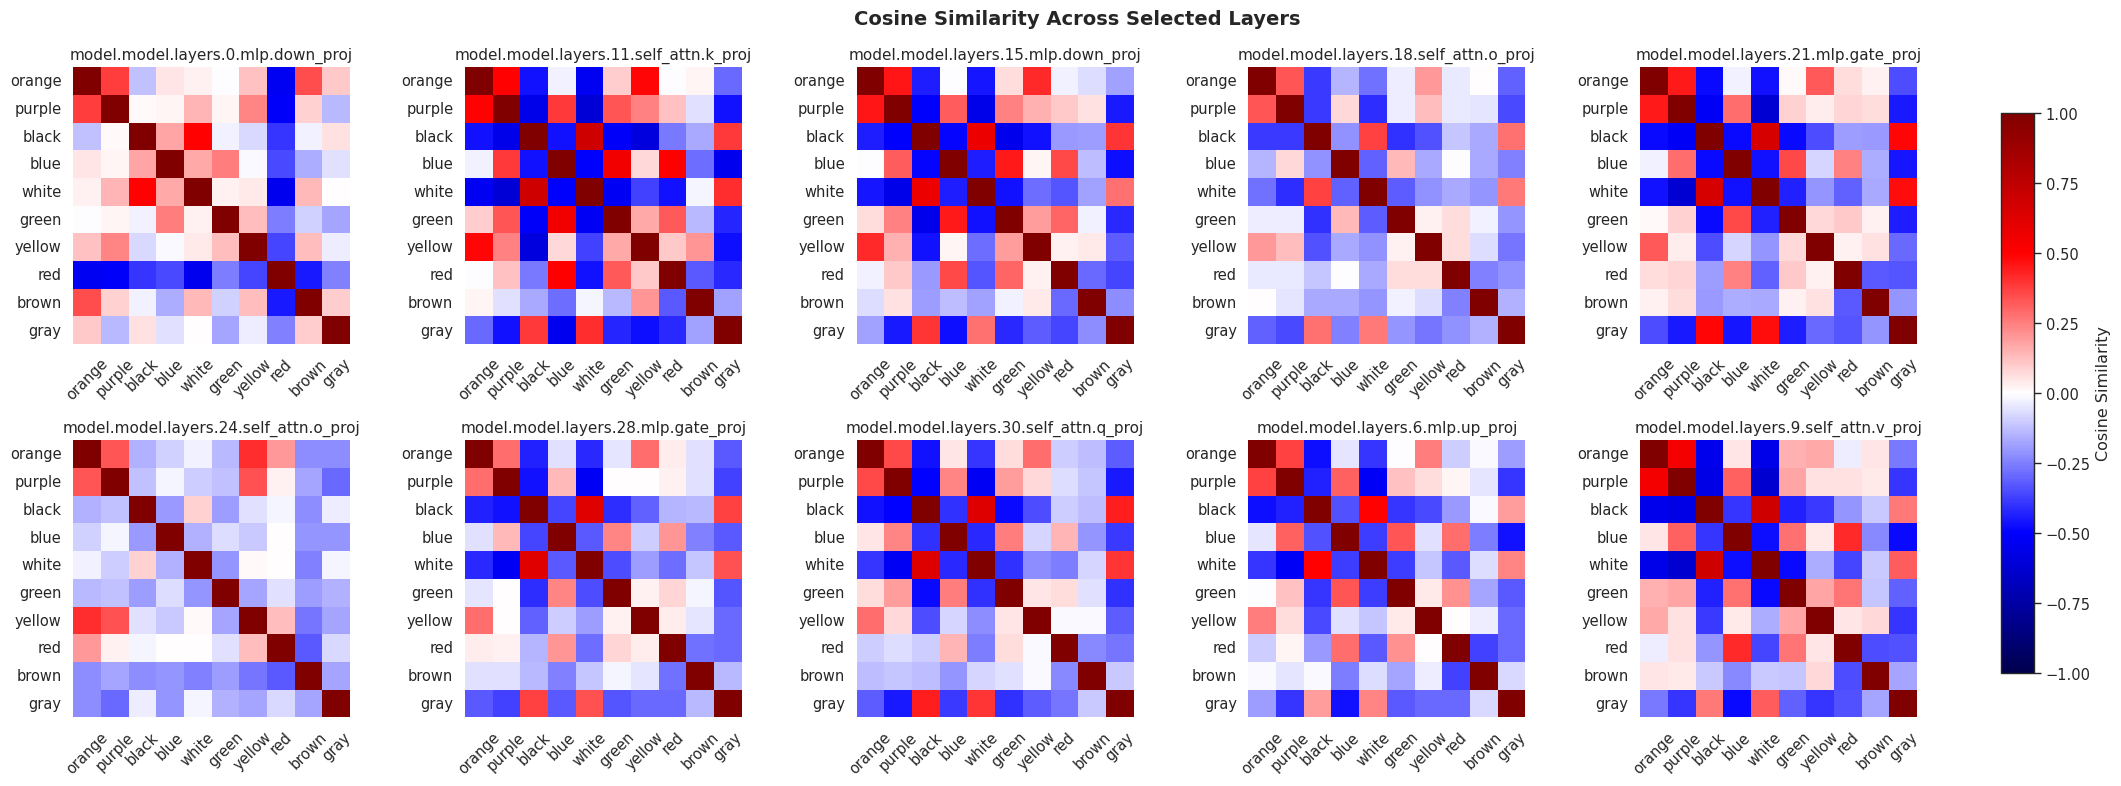

In [2]:
import os
from pathlib import Path
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------
# CONFIG
# -------------------------------------------------
sns.set_theme(context="paper", style="white", font_scale=1.2)

base_folder = "/projectnb/ivc-ml/divsp/fall2025/CS599/color-representations/outputs/steering_vectors/regular_templates/fundamental_colors"

# -------------------------------------------------
# FUNCTIONS
# -------------------------------------------------
def compute_cosine_similarity(vectors):
    normed = F.normalize(vectors, dim=1)
    return (normed @ normed.T).cpu().numpy()

def process_folder(base_dir):
    base_path = Path(base_dir)
    color_folders = [p for p in base_path.iterdir() if p.is_dir()]
    all_layers = {}

    for color_dir in color_folders:
        for pt_file in sorted(color_dir.glob("*.pt")):
            layer_name = pt_file.stem
            vec = torch.load(pt_file, map_location="cpu")
            if isinstance(vec, dict):
                vec = vec.get("vectors") or next(iter(vec.values()))
            all_layers.setdefault(layer_name, []).append((color_dir.name, vec))
    return all_layers

# -------------------------------------------------
# LOAD LAYERS
# -------------------------------------------------
layers = process_folder(base_folder)
layer_names = sorted(layers.keys(), key=lambda x: int(x.split("_")[-1]) if x.split("_")[-1].isdigit() else x)

# select 10 evenly spaced layers excluding first & last
if len(layer_names) <= 12:
    selected_layers = layer_names[1:-1]
else:
    idx = np.linspace(1, len(layer_names)-2, 10, dtype=int)
    selected_layers = [layer_names[i] for i in idx]

# -------------------------------------------------
# PLOT GRID
# -------------------------------------------------
n = len(selected_layers)
rows, cols = 2, 5

fig, axes = plt.subplots(rows, cols, figsize=(22, 8))
axes = axes.flatten()

for ax, layer_name in zip(axes, selected_layers):
    entries = layers[layer_name]
    color_names, all_vecs = [], []

    for color, vec in entries:
        color_names.append(color)
        vec_flat = vec.flatten(start_dim=1) if vec.ndim > 1 else vec.unsqueeze(0)
        all_vecs.append(vec_flat.mean(0))

    all_vecs = torch.stack(all_vecs)
    sim = compute_cosine_similarity(all_vecs)

    sns.heatmap(
        sim,
        ax=ax,
        cmap="seismic",
        vmin=-1, vmax=1,
        cbar=False,
        xticklabels=color_names,
        yticklabels=color_names,
        square=True
    )
    ax.set_title(layer_name, fontsize=11)
    ax.tick_params(axis='x', rotation=45)

# remove unused axes if <10
for j in range(n, rows*cols):
    fig.delaxes(axes[j])

# colorbar to the right
# (we use the last heatmap as handle)
cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
norm = plt.Normalize(vmin=-1, vmax=1)
sm = plt.cm.ScalarMappable(cmap="seismic", norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cax, label="Cosine Similarity")

plt.suptitle("Cosine Similarity Across Selected Layers", fontweight="bold", fontsize=14)
plt.tight_layout(rect=[0, 0, 0.90, 1])  # leave space for colorbar
plt.show()


In [3]:
import torch
import torch.nn.functional as F
from pathlib import Path
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------------------------
# CONFIG
# ------------------------------------------------------------------------------
root = Path("/projectnb/ivc-ml/divsp/fall2025/CS599/color-representations/outputs/steering_vectors/regular_templates/fundamental_colors")
out_dir = Path(".regular_templates_plots")
out_dir.mkdir(exist_ok=True)

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

# ------------------------------------------------------------------------------
# LOAD DATA
# ------------------------------------------------------------------------------
colors = sorted([d.name for d in root.iterdir() if d.is_dir()])
vectors = {}

for color in colors:
    for f in (root / color).glob("*.pt"):
        layer = f.stem
        v = torch.load(f).flatten().float()
        v = F.normalize(v, dim=0)
        vectors.setdefault(layer, {})[color] = v

layers = sorted(vectors.keys())

# ------------------------------------------------------------------------------
# BUILD DATAFRAME FOR BOXPLOT (COLOR-PAIR DISTRIBUTIONS ACROSS LAYERS)
# ------------------------------------------------------------------------------
records = []
for c1, c2 in itertools.combinations(colors, 2):
    pair_name = f"{c1}-{c2}"
    for layer in layers:
        sim = torch.dot(vectors[layer][c1], vectors[layer][c2]).item()
        records.append({"pair": pair_name, "layer": layer, "similarity": sim})

df_pairs = pd.DataFrame(records)

# ------------------------------------------------------------------------------
# BOX PLOT: PAIRWISE COLOR SIMILARITY DISTRIBUTION
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(15, 5))

palette = sns.color_palette("tab20", df_pairs["pair"].nunique())

sns.boxplot(
    data=df_pairs,
    x="pair",
    y="similarity",
    palette=palette,
    showfliers=False,
    linewidth=1.2,
    ax=ax,
)

ax.set_title("Pairwise Color Steering Similarity Across Layers", fontweight="bold")
ax.set_xlabel("Color Pair")
ax.set_ylabel("Cosine Similarity")
plt.xticks(rotation=90)
plt.tight_layout()

fig.savefig(out_dir / "color_pair_similarity_boxplot.png", dpi=400, bbox_inches="tight")
plt.close(fig)

# ------------------------------------------------------------------------------
# LINE PLOT: AVG LAYER SIMILARITY ACROSS ALL COLOR PAIRS
# ------------------------------------------------------------------------------
# ------------------------------------------------------------------------------
# LINE PLOT: AVG LAYER SIMILARITY ACROSS ALL COLOR PAIRS + mark max layer
# ------------------------------------------------------------------------------
layer_means = []
layer_index = 0
for layer in layers:
    n = len(colors)
    M = np.zeros((n, n))
    for i, c1 in enumerate(colors):
        for j, c2 in enumerate(colors):
            if i != j:
                M[i, j] = torch.dot(vectors[layer][c1], vectors[layer][c2]).item()
    vals = M[np.triu_indices(n, k=1)]
    layer_means.append({
        "layer": layer_index,
        "layer_name": layer,
        "avg_similarity": vals.mean()
    })
    layer_index += 1

df_layer = pd.DataFrame(layer_means)
plt.rcParams.update({
    "font.size": 16,          # default text size
    "axes.titlesize": 18,     # title
    "axes.labelsize": 16,     # x/y labels
    "xtick.labelsize": 14,    # x tick labels
    "ytick.labelsize": 14,    # y tick labels
    "legend.fontsize": 14,    # legend text
})


fig, ax = plt.subplots(figsize=(25, 8))

sns.lineplot(
    data=df_layer,
    x="layer",
    y="avg_similarity",
    marker="o",
    linewidth=2.2,
    markersize=7,
    ax=ax,
)

ax.set_title("Average Steering Cosine Similarity per Layer", fontweight="bold")
ax.set_xlabel("Layer Index")
ax.set_ylabel("Avg Cosine Similarity (off-diagonal)")
plt.xticks(rotation=90)

# ---- find max layer ----
idx_max = df_layer["avg_similarity"].idxmax()
max_row = df_layer.loc[idx_max]
x, y = max_row["layer"], max_row["avg_similarity"]

# ---- draw red vertical line at max ----
ax.axvline(x=x, color="red", linestyle="--", linewidth=2, alpha=0.9)

# ---- text label below x-axis with layer name ----
ax.text(
    x,
    ax.get_ylim()[0],   # just below axis
    max_row["layer_name"],
    rotation=0,
    fontsize=20,
    ha="center",
    va="top",
    color="red",
    fontweight="bold"
)

# extra space so the label doesn’t clip
plt.tight_layout(rect=[0,0.02,1,1])

fig.savefig(out_dir / "layer_avg_similarity_maxline.png", dpi=400, bbox_inches="tight")
plt.close(fig)

print(f"Saved plots to: {out_dir.resolve()}")



/scratch/ipykernel_2555859/2344098598.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


Saved plots to: /projectnb/ivc-ml/divsp/fall2025/CS599/color-representations/notebooks/.regular_templates_plots


In [11]:
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

plt.rcParams.update({
    "font.size": 10,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
})


# -------- USER CONFIG --------
root = "/projectnb/ivc-ml/divsp/fall2025/CS599/color-representations/outputs/steering_vectors/regular_templates/fundamental_colors"
variance_threshold = 0.95
save_dir = "./color_pca_results_"
os.makedirs(save_dir, exist_ok=True)
# -----------------------------

# Find color names
color_names = sorted([
    d for d in os.listdir(root) 
    if os.path.isdir(os.path.join(root, d))
])

if len(color_names) == 0:
    raise RuntimeError("No color folders found.")

# Use the first color folder to extract layer filenames
first_color_dir = os.path.join(root, color_names[0])
layer_files = sorted([f for f in os.listdir(first_color_dir) if f.endswith(".pt")])

if len(layer_files) == 0:
    raise RuntimeError("No .pt files in first color folder — cannot infer layers.")

# layer names = file stem
layers = [os.path.splitext(f)[0] for f in layer_files]
print(f"Detected {len(layers)} layers")

results = []

for layer_name in layers:
    X_list = []

    for color in color_names:
        file_path = os.path.join(root, color, f"{layer_name}.pt")
        if not os.path.exists(file_path):
            print(f"[WARNING] Missing file {file_path}, skipping layer {layer_name}")
            break

        vec = torch.load(file_path)
        vec = vec / vec.norm()
        if not isinstance(vec, torch.Tensor):
            raise RuntimeError(f"{file_path} did not load a Tensor (contains dict?)")

        X_list.append(vec.detach().cpu().float().numpy())

    else:  # executed only if no 'break'
        X = np.stack(X_list, axis=0)
        X_centered = X - X.mean(axis=0, keepdims=True)

        print(X.shape, X_centered.shape)

        pca = PCA()
        pca.fit(X)

        expl = pca.explained_variance_ratio_
        cum = np.cumsum(expl)
        k = np.searchsorted(cum, variance_threshold) + 1

        results.append((layer_name, k))

                # ---- Plot ----
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))

        # Scree
        axs[0].plot(np.arange(1, len(cum)+1), cum, marker="o")
        axs[0].axhline(variance_threshold, linestyle="--")
        axs[0].set_xlabel("PC")
        axs[0].set_ylabel("Cumulative Var Explained")
        axs[0].set_title(f"Scree\nk={k} PCs @ {variance_threshold*100:.0f}%")

        # 2D PCA scatter
        X2 = pca.transform(X_centered)[:, :2]
        for i, c in enumerate(color_names):
            axs[1].scatter(X2[i,0], X2[i,1])
            axs[1].text(X2[i,0], X2[i,1], c)
        axs[1].set_xlabel("PC1")
        axs[1].set_ylabel("PC2")
        axs[1].set_title(f"2D PCA\n(layer {layer_name}, k={k})")

        fig.suptitle(f"Color PCA — {layer_name} (k={k})")

        fig.tight_layout()

        out = os.path.join(save_dir, f"{layer_name.replace('.', '_')}.png")
        plt.savefig(out, dpi=100)
        plt.close()

        print(f"[DONE] {layer_name}: k={k}   saved {out}")

# Save best 5 layers (smallest k)
results_sorted = sorted(results, key=lambda x: x[1])
top5 = results_sorted[:5]

json_path = os.path.join(save_dir, "top5_layers.json")
with open(json_path, "w") as f:
    json.dump({l:int(k) for l,k in top5}, f, indent=2)

print("\nTop 5 layers needing smallest dim:")
for layer, k in top5:
    print(f"{layer}: {k}")

print(f"\nResults JSON saved: {json_path}")


Detected 226 layers
(10, 4096) (10, 4096)
[DONE] model.model.embed_tokens: k=2   saved ./color_pca_results_/model_model_embed_tokens.png
(10, 4096) (10, 4096)
[DONE] model.model.layers.0.mlp.down_proj: k=8   saved ./color_pca_results_/model_model_layers_0_mlp_down_proj.png
(10, 14336) (10, 14336)
[DONE] model.model.layers.0.mlp.gate_proj: k=8   saved ./color_pca_results_/model_model_layers_0_mlp_gate_proj.png
(10, 14336) (10, 14336)
[DONE] model.model.layers.0.mlp.up_proj: k=8   saved ./color_pca_results_/model_model_layers_0_mlp_up_proj.png
(10, 1024) (10, 1024)
[DONE] model.model.layers.0.self_attn.k_proj: k=2   saved ./color_pca_results_/model_model_layers_0_self_attn_k_proj.png
(10, 4096) (10, 4096)
[DONE] model.model.layers.0.self_attn.o_proj: k=9   saved ./color_pca_results_/model_model_layers_0_self_attn_o_proj.png
(10, 4096) (10, 4096)
[DONE] model.model.layers.0.self_attn.q_proj: k=2   saved ./color_pca_results_/model_model_layers_0_self_attn_q_proj.png
(10, 1024) (10, 1024)
[